## 4.-SMOTE

Objetivo, Binario 1/0 definido por el percentil 75 de la variable Price de la Base de datos dada que determina aquellas viviendas de precio más elevado como el la primera Red salvo que vamos a desbalancear nuestra muestra de categorías 1 para el aprendizaje de la técnica.

#### Breve visión de Synthetic Minority Oversampling Technique

Un problema de clasificación desequilibrada sucede cuando existen muy poco casos de la clase o clases minoritarias para que el modelo pueda aprender 'the decision boundary'. A priori una forma de resolver este problema es sobremuestrear la clase minoritaria. Con esto podemos equilibrar la muestra pero no aporta información al modelo.
La alternativa es sitetizar nuevos ejemplos de la clase minoritara.

This technique was described by Nitesh Chawla, et al. in their 2002 paper named for the technique titled “SMOTE: Synthetic Minority Over-sampling Technique.”

SMOTE funciona seleccionando ejemplos que están cerca en el espacio de características, simulando una línea entre los ejemplos en el espacio de características y generando una nueva muestra en un punto a lo largo de esa línea.
Primero se elige un ejemplo aleatorio para posteriormente seleccionar los k vecinos más cercanos. Se elige un vecino seleccionado al azar y se crea un ejemplo sintético en un punto seleccionado al azar entre los dos ejemplos en el espacio de características.

Esta metodología la podemos emplear para generar tantos ejemplos sintéticos de la clase minoritaria como consideremos necesario.

Para abordar el trabajo con nuestra técnica vamos a 'manipular' nuestra base de datos creada en los anteriores modelos reduciendo en el caso del modelo binario el número de unos de forma significativa y generar nuevos ejemplos sintéticos con la metodología SMOTE.

###  índice
##### 4.1.- Importamos la BBDD
##### 4.2.- EDA html
##### 4.3.- Balanceo de la BBDD
##### 4.4.- Tratamiento de Variables. Limpieza y preparación
##### 4.5.- Split Train, Validation, Test
##### 4.6.- Transformación de la Escala de los Datos
##### 4.7.- Without SMOTE y un Random Forest sencillo y rápido
##### 4.8.- SMOTE
##### 4.9.- Conclusiones
##### 4.10.- Alternativa 1. Modificamos Class Weights en el modelo
##### 4.11.- Alternativa 2. Naives Bayes
##### 4.12.- Ranking Resultados Recall Clase1
##### 
##### 



#### 4.1.- Importamos la BBDD

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')
import sweetviz as sv
from sklearn.naive_bayes import GaussianNB

In [333]:
# load the dataset
df = pd.read_csv('cluster.txt', sep=",")
df['y']= np.where(df['price']>=645000, 1, 0)
df.head()

,Unnamed: 0,X.1,X,Y,id,date,price,bedrooms,bathrooms,sqft_living,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,cluster,hclust,Cluster_final,y
0,1,1,3.762164,22.445021,7129300520,10/13/2014,221900.0,3,1.00,1180,...,0,98178,47.5112,-122.257,1340,5650,1,1,low,0
1,2,2,-24.035975,9.766915,6414100192,12/9/2014,538000.0,3,2.25,2570,...,1991,98125,47.7210,-122.319,1690,7639,1,2,top,0
2,3,3,5.217015,8.102678,5631500400,2/25/2015,180000.0,2,1.00,770,...,0,98028,47.7379,-122.233,2720,8062,1,3,med,0
3,4,4,7.588730,18.967730,2487200875,12/9/2014,604000.0,4,3.00,1960,...,0,98136,47.5208,-122.393,1360,5000,2,1,low,0
4,5,5,0.666181,3.939548,1954400510,2/18/2015,510000.0,3,2.00,1680,...,0,98074,47.6168,-122.045,1800,7503,3,3,med,0


#### 4.2.- EDA html

In [288]:
#analyzing the dataset
advert_report = sv.analyze(df)
#display the report
advert_report.show_html('Advertising.html')

:FEATURES DONE:                    |                     | [  0%]   00:41  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:09  -> (00:00 left)


Creating Associations graph... DONE!


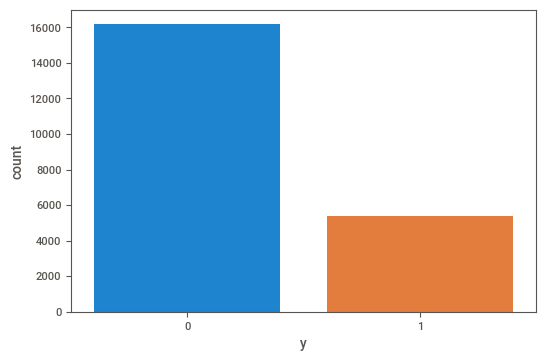

In [334]:
sns.countplot(x = 'y', data=df)

In [335]:
df['y'] .value_counts()

0    16186
1     5411
Name: y, dtype: int64

#### 4.3.- Balanceo de la BBDD

Tenemos en la base actual 33% aproximado de los casos 1. Vamos a variar esta relación y quedarnos con un 2% de los casos positivos para aplicar la técnica. 325 casos aproximadamente.

In [336]:
base0=df[df['y']==0]

In [337]:
base1=df[df['y']==1]

In [338]:
sample1=base1.sample(n=325, random_state=737)

In [339]:
sample1

,Unnamed: 0,X.1,X,Y,id,date,price,bedrooms,bathrooms,sqft_living,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,cluster,hclust,Cluster_final,y
19455,19456,19456,8.944327,0.113959,2566300100,3/27/2015,1390000.0,5,1.75,2650,...,0,98004,47.6260,-122.213,2780,13204,2,3,med,1
12201,12202,12202,-14.491330,12.231148,4154303215,8/28/2014,902000.0,3,2.75,3240,...,0,98118,47.5670,-122.273,2700,7200,1,6,med,1
4395,4396,4396,-8.618289,-16.262289,524069019,11/20/2014,1150000.0,4,3.25,4400,...,0,98075,47.5927,-122.064,3240,9791,3,8,top,1
11367,11368,11368,-1.557660,-16.809941,3860900003,6/17/2014,1170000.0,4,2.50,2570,...,0,98004,47.5930,-122.197,2570,9588,3,8,top,1
896,897,897,-4.115891,-14.979852,4298100240,8/5/2014,660000.0,3,2.50,2680,...,0,98077,47.7637,-122.050,2670,32130,3,8,top,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4963,4964,4964,-26.676326,5.622063,6918700130,8/11/2014,749000.0,3,2.50,3380,...,2003,98008,47.6276,-122.122,1810,7308,3,2,top,1
10368,10369,10369,-5.058434,27.684397,8825900310,12/11/2014,730000.0,4,2.50,2030,...,0,98115,47.6753,-122.311,1980,4080,1,1,low,1
10617,10618,10618,11.302730,0.759022,2581900036,6/12/2014,743000.0,3,1.75,2110,...,0,98040,47.5402,-122.216,2560,10992,2,3,med,1
13947,13948,13948,-5.597032,-14.262017,924069210,6/3/2014,695000.0,4,2.50,2961,...,0,98075,47.5839,-122.052,2620,17749,3,8,top,1


Generamos un nuevo df con todos los casos 0 y la muestra de 325 con los valores 1

In [340]:
base_smote=pd.concat([base0,sample1])

Comprobamos la nueva distribución de la Base de Datos

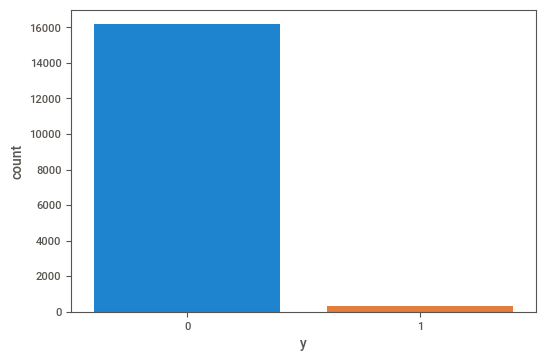

In [341]:
sns.countplot(x = 'y', data=base_smote)

In [342]:
base_smote['y'] .value_counts()

0    16186
1      325
Name: y, dtype: int64

#### 4.4.- Tratamiento de Variables. Limpieza y preparación

In [343]:
# tratamiento de la Variable Cluster a Nivel Dummy
dummy=pd.get_dummies(base_smote['Cluster_final'])
base_smote=pd.concat([base_smote,dummy],axis=1)
# tratamiento yr_renovated a flag 
base_smote['renova'] = np.where(base_smote['yr_renovated']>0, 1, 0)
# tratamiento yr_built Numero de anyos de la vivienda
base_smote['max_year']     = max(base_smote['yr_built'])
base_smote['anyos']=(base_smote['max_year'] -base_smote['yr_built'])
# Tratamiento de las fechas, crearemos una variable llamada Antigüedad en días de una vivienda 
#con respecto a la máxima fecha de la base de datos.
base_smote['max']     = max(base_smote['date'])
base_smote['max']     = pd.to_datetime(base_smote['max'] )
base_smote['date']    = pd.to_datetime(base_smote['date'])
base_smote['antiguedad']=(base_smote['date'] -base_smote['max']).apply(lambda x: x.days)

In [344]:
base_smote.head()

,Unnamed: 0,X.1,X,Y,id,date,price,bedrooms,bathrooms,sqft_living,...,Cluster_final,y,low,med,top,renova,max_year,anyos,max,antiguedad
0,1,1,3.762164,22.445021,7129300520,2014-10-13,221900.0,3,1.00,1180,...,low,0,1,0,0,0,2015,60,2014-09-09,34
1,2,2,-24.035975,9.766915,6414100192,2014-12-09,538000.0,3,2.25,2570,...,top,0,0,0,1,1,2015,64,2014-09-09,91
2,3,3,5.217015,8.102678,5631500400,2015-02-25,180000.0,2,1.00,770,...,med,0,0,1,0,0,2015,82,2014-09-09,169
3,4,4,7.588730,18.967730,2487200875,2014-12-09,604000.0,4,3.00,1960,...,low,0,1,0,0,0,2015,50,2014-09-09,91
4,5,5,0.666181,3.939548,1954400510,2015-02-18,510000.0,3,2.00,1680,...,med,0,0,1,0,0,2015,28,2014-09-09,162


In [345]:
del base_smote['date']
del base_smote['max_year']
del base_smote['max']
del base_smote['cluster'] # eliminamos los otros análisis clústers
del base_smote['hclust']
del base_smote['price']
del base_smote['Cluster_final']
del base_smote['yr_renovated']
del base_smote['yr_built']
base_smote=base_smote.set_index('id')
X=base_smote.iloc[:, 4:30]
X.head(5)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,long,sqft_living15,sqft_lot15,y,low,med,top,renova,anyos,antiguedad
id,,,,,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,-122.257,1340,5650,0,1,0,0,0,60,34
6414100192,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,-122.319,1690,7639,0,0,0,1,1,64,91
5631500400,2,1.00,770,10000,1.0,0,0,3,6,770,...,-122.233,2720,8062,0,0,1,0,0,82,169
2487200875,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,-122.393,1360,5000,0,1,0,0,0,50,91
1954400510,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,-122.045,1800,7503,0,0,1,0,0,28,162


In [346]:
y=base_smote['y']
del X['y']

#### 4.5.- Split Train, Validation, Test.

In [347]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=737)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval,random_state=737)

#### 4.6.- Transformación de la Escala de los Datos

In [348]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

#### 4.7.- Without SMOTE y un Random Forest sencillo y rápido

In [140]:
clf = RandomForestClassifier(max_depth=10, random_state=737)

In [141]:
# fit the model
clf.fit(X_train, y_train.ravel())

# prediction for training dataset
train_pred = clf.predict(X_train)

# prediction for training dataset
val_pred = clf.predict(X_val)

# prediction for testing dataset
test_pred = clf.predict(X_test)

In [142]:
print('Accuracy score for Training Dataset   = ', accuracy_score(train_pred, y_train))
print('Accuracy score for Validation Dataset = ', accuracy_score(val_pred, y_val))
print('Accuracy score for Testing Dataset    = ', accuracy_score(test_pred, y_test))

Accuracy score for Training Dataset   =  0.991923950534197
Accuracy score for Validation Dataset =  0.9833459500378501
Accuracy score for Testing Dataset    =  0.9866787768695126


In [149]:
print('Confusion Matrix - Validation Dataset')
confusion_matrix(y_train, train_pred)

Confusion Matrix - Validation Dataset


array([[11653,     0],
       [   96,   138]])

In [150]:
print('Confusion Matrix - Validation Dataset')
confusion_matrix(y_val, val_pred)

Confusion Matrix - Validation Dataset


array([[1294,    1],
       [  21,    5]])

In [152]:
print('Confusion Matrix - Test Dataset')
confusion_matrix(y_test, test_pred)

Confusion Matrix - Test Dataset


array([[3237,    1],
       [  43,   22]])

In [148]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3238
           1       0.96      0.34      0.50        65

    accuracy                           0.99      3303
   macro avg       0.97      0.67      0.75      3303
weighted avg       0.99      0.99      0.98      3303



Vemos en los resultados del RF que obtenemos unas métricas de Accuracy muy altas, 0.99 en el caso de la población Test pero muy malos resultados a la hora de predecir el grupo 1. 
Es por tanto necesario y conveniente aplicar las Técnicas de SMOTE

#### 4.8.- With SMOTE

In [153]:
sm = SMOTE(random_state = 737)

In [154]:
X_train_new, y_train_new = sm.fit_sample(X_train, y_train.ravel())

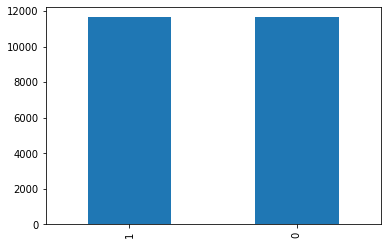

In [156]:
# observe that data has been balanced
pd.Series(y_train_new).value_counts().plot.bar()

Una vez balanceados los datos de forma sintética vamos a reentrenar y validar el modelo RF

In [157]:
# fit the model
clf.fit(X_train_new, y_train_new)

# prediction for Training data
train_pred_sm = clf.predict(X_train_new)

# prediction for validation data
val_pred_sm = clf.predict(X_val)

# prediction for Testing data
test_pred_sm = clf.predict(X_test)

In [159]:
print('Accuracy score for SMOTE Training Dataset = ', accuracy_score(train_pred_sm, y_train_new))
print('Accuracy score for Validation Dataset = ', accuracy_score(val_pred_sm, y_val))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred_sm, y_test))

Accuracy score for SMOTE Training Dataset =  0.9928344632283532
Accuracy score for Validation Dataset =  0.8872066616199848
Accuracy score for Testing Dataset =  0.8907054193157735


In [160]:
print('Confusion Matrix - TRAIN SMOTE Dataset')
confusion_matrix(y_train_new, train_pred_sm)

Confusion Matrix - Validation SMOTE Dataset


array([[11512,   141],
       [   26, 11627]])

In [162]:
print('Confusion Matrix - Validation SMOTE Dataset')
confusion_matrix(y_val, val_pred_sm)

Confusion Matrix - Validation SMOTE Dataset


array([[1148,  147],
       [   2,   24]])

In [163]:
print('Confusion Matrix - Test SMOTE Dataset')
confusion_matrix(y_test, test_pred_sm)

Confusion Matrix - Test SMOTE Dataset


array([[2884,  354],
       [   7,   58]])

#### 4.9.- Conclusiones

Observando los resultados de la distribucón de la población Test concluímos que hemos mejorado mucho la predicción de la categoría 1 aplicando las técnicas SMOTE. Aunque ya sabemos que no nos podemos fiar sólo del Accuracy tal y cómo hemos visto arriba.

In [164]:
print(classification_report(y_test, test_pred_sm))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      3238
           1       0.14      0.89      0.24        65

    accuracy                           0.89      3303
   macro avg       0.57      0.89      0.59      3303
weighted avg       0.98      0.89      0.93      3303



En nuestro caso queríamos evitar a toda costa los Falsos Negaticos por lo que vamos a trabajar con el Recall, ya que partimos de la hipótesis de que hay un alto costo asociado al Falso Negativo. Viendo el resultado de 0.89 podemos estar más que satisfechos, en el RF sin SMOTE el Recall era de 0.34.

#### 4.10.- Alternativa 1. Modificamos los pesos de las Clases
dentro del modelo RF vamos a acceder al class_weight y vamos a indicarle que balancee las muestras

In [349]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=737)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval,random_state=737)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [350]:
clf = RandomForestClassifier(max_depth=10, random_state=737,class_weight='balanced')

In [351]:
# fit the model
clf.fit(X_train, y_train.ravel())

# prediction for training dataset
train_pred = clf.predict(X_train)

# prediction for training dataset
val_pred = clf.predict(X_val)

# prediction for testing dataset
test_pred = clf.predict(X_test)

In [352]:
print('Accuracy score for Training Dataset   = ', accuracy_score(train_pred, y_train))
print('Accuracy score for Validation Dataset = ', accuracy_score(val_pred, y_val))
print('Accuracy score for Testing Dataset    = ', accuracy_score(test_pred, y_test))

Accuracy score for Training Dataset   =  0.9924287036258097
Accuracy score for Validation Dataset =  0.975775927327782
Accuracy score for Testing Dataset    =  0.9851650015137754


In [353]:
print('Confusion Matrix - Test Dataset')
confusion_matrix(y_test, test_pred)

Confusion Matrix - Test Dataset


array([[3218,   20],
       [  29,   36]])

In [354]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3238
           1       0.64      0.55      0.60        65

    accuracy                           0.99      3303
   macro avg       0.82      0.77      0.79      3303
weighted avg       0.98      0.99      0.98      3303



Conclusiones, con la modificación del parámetro class weight dentro del modelo del RF vemos que se mejoran los resultados del recall con respecto a los datos orginales y la ejecución del modelo  0.55 sobre 0.34 que es nuestro objetivo fundamental pero no mejoran los resultados del SMOTE que son 0.89

#### 4.11.- Alternativa 2. Naives Bayes

Plantearemos el modelo Naives Bayes como segunda alternativa parametrizando los class prior como un array con diferentes pesos y valoraremos los resultados comparándolos con los anteriores.

In [409]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=737)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval,random_state=737)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.fit_transform(X_val)
X_test  = scaler.fit_transform(X_test)

In [365]:
# Create Gaussian Naive Bayes object with prior probabilities of each class
clf = GaussianNB(priors=[0.5, 0.5])

# fit the model
clf.fit(X_train, y_train.ravel())

# prediction for training dataset
train_pred = clf.predict(X_train)

# prediction for training dataset
val_pred = clf.predict(X_val)

# prediction for testing dataset
test_pred = clf.predict(X_test)

In [366]:
print('Accuracy score for Training Dataset   = ', accuracy_score(train_pred, y_train))
print('Accuracy score for Validation Dataset = ', accuracy_score(val_pred, y_val))
print('Accuracy score for Testing Dataset    = ', accuracy_score(test_pred, y_test))

Accuracy score for Training Dataset   =  0.8876924371161773
Accuracy score for Validation Dataset =  0.8932626797880394
Accuracy score for Testing Dataset    =  0.8888888888888888


In [367]:
print('Confusion Matrix - Test Dataset')
confusion_matrix(y_test, test_pred)

Confusion Matrix - Test Dataset


array([[2892,  346],
       [  21,   44]])

In [368]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      3238
           1       0.11      0.68      0.19        65

    accuracy                           0.89      3303
   macro avg       0.55      0.79      0.57      3303
weighted avg       0.98      0.89      0.93      3303



Obtenemos un recall de 0.68, mejoramos lode resultados del RF desbalanceado que era 0.10, así como los resultados del RF balanceado con los pesos cuyo recall era 0.55. Pero no mejoran los resultados del SMOTE.

#### 4.12.- Ranking Resultados Recall Clase1
##### 1.- 0.89 SMOTE
##### 2.- 0.68 Naive Bayes
##### 3.- 0.55 Random Forest Class Weitgh
##### 4.- 0.10 Random Forest muestra original

## 5.-Problema sintético multiclase desequilibrado

Objetivo, Multiclase definido por la variable Cluster Final creada en la práctica de la asignatura ML I con tres categorías Low, Med y Top pero en este caso vamos a desbalancear la categoría Top al 3% sobre a base total para el aprendizaje de la técnica.

###  índice
##### 5.1.-  Importamos la BBDD
##### 5.2.-  Balanceo de la BBDD
##### 5.3.-  Tratamiento de Variables. Limpieza y preparación
##### 5.4.-  One Hot Encoding
##### 5.5.-  Split Train, Validation, Test
##### 5.6.-  Transformación de la Escala de los Datos
##### 5.7.- Parámetros, entrenamiento y validación de la Red
##### 5.8.- Técnica de reequilibrado fundamentada: ponderación en entrenamiento
##### 5.9.- Validación y Conclusiones
##### 
##### 


#### 5.1.- Importamos la BBDD

In [369]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#Sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

#Keras

from keras.models import Sequential
from keras.layers import Dense

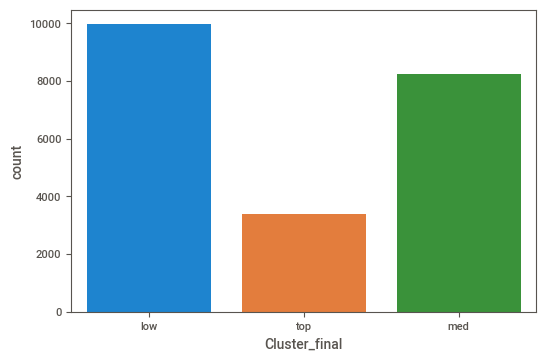

In [370]:
# load the dataset
new = pd.read_csv('cluster.txt', sep=",")
sns.countplot(x = 'Cluster_final', data=new)

In [371]:
new['Cluster_final'] .value_counts()

low    9970
med    8225
top    3402
Name: Cluster_final, dtype: int64

Desbalanceamos a un 3% de la distribución. Aproximadamente 546 Tops.

#### 5.2.- Balanceo de la BBDD

In [372]:
des_low=new[new['Cluster_final']=='low']
des_med=new[new['Cluster_final']=='med']
des_top=new[new['Cluster_final']=='top']

In [373]:
des_top_sam=des_top.sample(n=546, random_state=737)

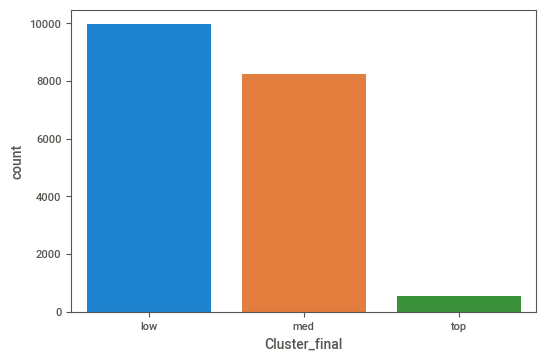

In [374]:
multi_des =pd.concat([des_low,des_med])
multi_des =pd.concat([multi_des,des_top_sam])
sns.countplot(x = 'Cluster_final', data=multi_des)

In [375]:
multi_des['Cluster_final'] .value_counts()

low    9970
med    8225
top     546
Name: Cluster_final, dtype: int64

#### 5.3.- Tratamiento de Variables. Limpieza y preparación
Tratamiento ordinal de la variable Cluster, no es necesario transformarla a Dummy ya que es nuestra variable Objetivo

In [376]:
enc = OrdinalEncoder()
multi_des[["Cluster_final"]] = enc.fit_transform(multi_des[["Cluster_final"]])
multi_des['Cluster_final'] .value_counts()

0.0    9970
1.0    8225
2.0     546
Name: Cluster_final, dtype: int64

In [378]:
# tratamiento yr_renovated a flag 
multi_des['renova'] = np.where(multi_des['yr_renovated']>0, 1, 0)

In [379]:
# tratamiento yr_built Numero de anyos de la vivienda
multi_des['max_year']     = max(multi_des['yr_built'])
multi_des['anyos']=(multi_des['max_year'] -multi_des['yr_built'])

In [381]:
# Tratamiento de las fechas, crearemos una variable llamada Antigüedad en días de una vivienda 
#con respecto a la máxima fecha de la base de datos.
multi_des['max']     = max(multi_des['date'])
multi_des['max']     = pd.to_datetime(multi_des['max'] )
multi_des['date']    = pd.to_datetime(multi_des['date'])
multi_des['antiguedad']=(multi_des['date'] -multi_des['max']).apply(lambda x: x.days)

In [382]:
del multi_des['date']
del multi_des['max_year']
del multi_des['max']
del multi_des['cluster'] # eliminamos los otros análisis clústers
del multi_des['hclust']
del multi_des['yr_renovated']
del multi_des['yr_built']
multi_des=multi_des.set_index('id')
X=multi_des.iloc[:, 4:30]
X.head(5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,Cluster_final,renova,anyos,antiguedad
id,,,,,,,,,,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,98178,47.5112,-122.257,1340,5650,0.0,0,60,-226
2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,910,98136,47.5208,-122.393,1360,5000,0.0,0,50,-169
1321400060,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,...,0,98003,47.3097,-122.327,2238,6819,0.0,0,20,-334
3793500160,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,...,0,98038,47.3684,-122.031,2390,7570,0.0,0,12,-76
9212900260,468000.0,2,1.00,1160,6000,1.0,0,0,4,7,...,300,98115,47.6900,-122.292,1330,6000,0.0,0,73,-365


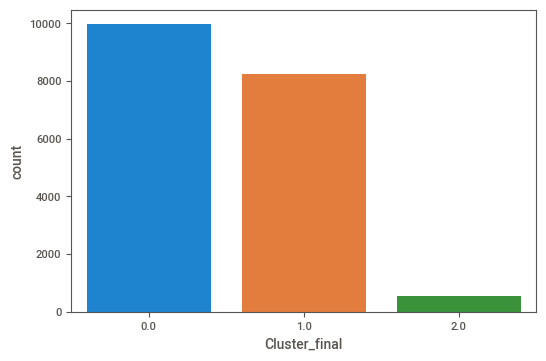

In [383]:
sns.countplot(x = 'Cluster_final', data=X)

In [384]:
y=X['Cluster_final']
del X['Cluster_final']

#### 5.4.- One Hot Encoding

In [385]:
def hot_encoder(Y):
    values = np.array(Y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    #codificación binaria
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot_encoded_int = onehot_encoded.astype(int)
    
    return onehot_encoded_int

Y_bin = hot_encoder(Y)

#### 5.5.- Split Train, Validation, Test.

In [386]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, Y_bin, test_size=0.2, stratify=y,random_state=737)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval,random_state=737)

#### 5.6.- Transformación de la Escala de los Datos

In [387]:
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.fit_transform(X_val)
X_test  = scaler.fit_transform(X_test)

#### 5.7.- Parámetros, entrenamiento y validación de la Red

In [390]:
#MLP: Keras
nattributes   = 20 #Dimension de las muestras
neuronas      = 20 #Numero de neuronas en la capa oculta del MLP. Deberia validarse mediante validacion cruzada
PerrorMLPdes  = 0  #Por defecto
iteraciones   = 1  #Deberian ponerse al menos 10 y promediarlas...

Funcion de activacion RELU
loss categorical_crossentropy

In [402]:
print("Nº de neuronas en la capa oculta: ",neuronas)
#Definimos el modelo
model = Sequential()
model.add(Dense(neuronas, input_dim=nattributes, activation='relu')) #Podemos probar distintas funciones de activacion: tanh, sig...
model.add(Dense(n_clases, activation='softmax'))#sigmoide si no son exluyentes
  
#Compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #Tambien podemos probar otros costes. Por defecto usa el error cuadratico medio

#Entrenamos el modelo
model.fit(X_train, y_train, epochs=50,batch_size=32) #32 es el valor por defecto

#Obtenemos las etiquetas..
y_pred_proba = model.predict_proba(X_test) #salidas blandas-> Probabilidad de cada muestra de pertenecer a una clase
y_pred = np.argmax(y_pred_proba,axis=1) #Cogemos la clase a la que pertenece esa muestra con mayor probabilidad
y_test_bin = np.argmax(y_test,axis=1) #Para poder comparar las etiquetas
                                
#Calculamos probabilidad de fallo...
PerrorMLPdes = ((y_pred!=y_test_bin).sum())/len(y_test_bin) #OJO: aqui comparamos las etiquetas originales (no las de OHE)
mat_confdes = confusion_matrix(y_test_bin,y_pred)

print("Tasa de error con MLP ",PerrorMLPdes)
print("Matriz de confusion con MLP ", mat_confdes)


Nº de neuronas en la capa oculta:  20
Epoch 1/50
422/422 [==============================] - 3s 6ms/step - loss: 0.6370 - accuracy: 0.7581
Epoch 2/50
422/422 [==============================] - 3s 6ms/step - loss: 0.3182 - accuracy: 0.8965
Epoch 3/50
422/422 [==============================] - 3s 6ms/step - loss: 0.2470 - accuracy: 0.9146
Epoch 4/50
422/422 [==============================] - 3s 6ms/step - loss: 0.2211 - accuracy: 0.9197
Epoch 5/50
422/422 [==============================] - 3s 6ms/step - loss: 0.2074 - accuracy: 0.9229
Epoch 6/50
422/422 [==============================] - 3s 6ms/step - loss: 0.1980 - accuracy: 0.9244
Epoch 7/50
422/422 [==============================] - 2s 6ms/step - loss: 0.1927 - accuracy: 0.9257
Epoch 8/50
422/422 [==============================] - 2s 6ms/step - loss: 0.1890 - accuracy: 0.9265
Epoch 9/50
422/422 [==============================] - 2s 6ms/step - loss: 0.1856 - accuracy: 0.9278
Epoch 10/50
422/422 [==============================] - 2s 6ms/

In [403]:
 confusion_matrix(y_test_bin,y_pred)

array([[1916,   79,    0],
       [ 102, 1530,   13],
       [   4,   55,   50]])

In [404]:
print(classification_report(y_test_bin, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1995
           1       0.92      0.93      0.92      1645
           2       0.79      0.46      0.58       109

    accuracy                           0.93      3749
   macro avg       0.89      0.78      0.82      3749
weighted avg       0.93      0.93      0.93      3749



Vemos que aunque el Accuracy es bastante bueno la capacidad predictiva del modelo en la categoría 2 es mejorable con un 0.46 de Recall por lo que nos plantearemos alternativas.

#### 5.8.- Técnica de reequilibrado fundamentada: ponderación en entrenamiento

In [405]:
#Creamos el vector de pesos para la ponderación en entrenamiento
weight = np.zeros((y_train.shape[0])) 
for i in range(0,y_train.shape[0]):
    if(y_train[i,0]==1):
        weight[i] = Pr_H3/Pr_H1
    if(y_train[i,1]==1):
        weight[i] = Pr_H3/Pr_H2
    if(y_train[i,2]==1):
        weight[i] = 1

In [294]:
nattributes   = 20 #Dimension de las muestras
neuronas      = 20 #Numero de neuronas en la capa oculta del MLP. Deberia validarse mediante validacion cruzada
PerrorMLPreeq = 0 #Por defecto
iteraciones   = 1 #Deberian ponerse al menos 10 y promediarlas...

In [406]:
#Definimos el modelo
model = Sequential()
model.add(Dense(neuronas, input_dim=nattributes, activation='relu')) #Podemos probar distintas funciones de activacion: tanh, sig...
model.add(Dense(n_clases, activation='softmax'))

#Compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

# Fit the model
model.fit(X_train, y_train, epochs=50,sample_weight = weight,verbose=0)
    
#Obtenemos las salidas de las muestras de test
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba,axis=1) #Cogemos la clase a la que pertenece esa muestra con mayor probabilidad
y_test_bin = np.argmax(y_test,axis=1) #Para poder comparar las etiqueta

#Calculamos probabilidad de fallo...
PerrorMLPreeq = ((y_pred!=y_test_bin).sum())/len(y_test_bin) #OJO: aqui comparamos las etiquetas originales (no las de OHE)
mat_confreeq = confusion_matrix(y_test_bin,y_pred)

print("Tasa de error con ponderación en entrenamiento ",PerrorMLPreeq)
print("Matriz de confusion con ponderación en entrenamiento ", mat_confreeq)

Tasa de error con ponderación en entrenamiento  0.10589490530808215
Matriz de confusion con ponderación en entrenamiento  [[1909   75   11]
 [ 108 1344  193]
 [   4    6   99]]


In [407]:
 confusion_matrix(y_test_bin,y_pred)

array([[1909,   75,   11],
       [ 108, 1344,  193],
       [   4,    6,   99]])

#### 5.9.- Validación y Conclusiones

Vemos en los resultados que aunque el Accuracy el menor la capacidad de aprendizaje del modelo para la categoría 2 e mucho mejor que en el anterior caso.

In [408]:
print(classification_report(y_test_bin, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1995
           1       0.94      0.82      0.88      1645
           2       0.33      0.91      0.48       109

    accuracy                           0.89      3749
   macro avg       0.74      0.89      0.77      3749
weighted avg       0.93      0.89      0.90      3749



Aunque emperemos el Acc a 089 vemos que el Recall para la categoría 2 ha mejorado mucho con 0.91 cuando anteriormente teníamos 0.46.